In [2]:
#Import required packages
import matplotlib.pyplot as plt
import numpy as np
import torch 
import torch.nn as nn
import torch.optim as optim

from torch.autograd import grad
from torchdiffeq import odeint_adjoint
from torchdiffeq import odeint
import pandas as pd

In [6]:
class StiffODE(torch.nn.Module):
    def __init__(self):
        super(StiffODE, self).__init__()
        self.W = torch.nn.Parameter(torch.tensor([1.]), requires_grad=True)

    def forward(self, t, y):
        dy = self.W*y**2 - y**3
        return torch.stack([dy])

In [4]:
def loss_fun(true_y, pred):
    return ((true_y-pred)**2).mean()

In [10]:
func = StiffODE()
learning_rate = 0.01
num_iters = 100
optimizer = optim.Adam(func.parameters(), amsgrad=False, lr=learning_rate)
solver = 'dopri8'

np.random.seed(2021)
plt.close('all')

delta = 0.02
y0 = torch.tensor([delta])
t = torch.linspace(0, 2/delta, 100, requires_grad=False) 


loss = nn.MSELoss()

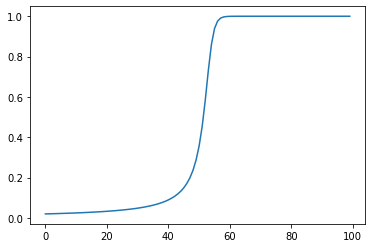

In [11]:
#Establish initial conditions
pred = odeint(func, y0, t, method=solver)
plt.plot(pred.detach().numpy())

In [12]:
loss_val = loss(true_y, pred)
loss_val.backward(retain_graph=True)
optimizer.step()

/Users/charlotte/opt/anaconda3/envs/thesis/lib/python3.9/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([100, 1])) that is different to the input size (torch.Size([100])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: Function _UncheckedAssignBackward returned an invalid gradient at index 1 - got [1, 1] but expected shape compatible with [1, 1, 1]

In [8]:
def loss_fun(gt, pred):
    return ((gt-pred)**2).mean()
    

class ODEFun(torch.nn.Module):
    def __init__(self):
        super(ODEFun, self).__init__()
        self.theta = torch.nn.Parameter(torch.tensor([0.0, 0.0]), requires_grad=True)
        
    def forward(self, t, y):
        S, I = y
        ds = self.theta[0]*S**2 - self.theta[1]*S**3
        di = self.theta[1]*S*I - I
        return torch.stack([ds, di])

def gt_fun(t, y):
    theta_0 = 5.5
    theta_1 = 8.0
    S, I = y
    ds = theta_0*S**2 - theta_1*S**3
    di = theta_1*S*I - I
    return torch.stack([ds, di])
        
true_y0 = torch.tensor([0.99, 0.01])
t = torch.linspace(0, 10, 100) 


# gt
with torch.no_grad():
    true_y = odeint(gt_fun, true_y0, t, method='dopri5')
    true_y_noise = true_y + torch.randn(true_y.shape)*0.02
    #true_y_adj = odeint_adjoint(gt_fun, true_y0, t, method='dopri5')


func = ODEFun()
lr = 0.01
num_iters = 1000
optimizer = torch.optim.RMSprop(func.parameters(), lr=lr)

print('itr loss theta_0 theta_1')
for ii in range(num_iters): 
    
    optimizer.zero_grad()
    
    pred = odeint(func, true_y0, t, method='dopri5')
    #pred = odeint_adjoint(func, true_y0, t, method='dopri5')
    loss = loss_fun(true_y_noise, pred)
    
    loss.backward()
    optimizer.step()
    
    if ii % 10 == 0:
        print(ii, round(loss.item(), 4), round(func.theta[0].item(), 4), round(func.theta[1].item(), 4))
    

# Note: here the GT values are hardcoded - fix
print('\n')
print('GT  : theta_0: {:2.2}, theta_1: {:2.2}'.format(5.5, 8.0))
print('Pred: theta_0: {:2.2}, theta_1: {:2.2}'.format(round(func.theta[0].item(), 4), round(func.theta[1].item(), 4)))



plt.figure(1)
with torch.no_grad():
    plt.plot(t, true_y[:,0], 'C0', lw=3, label='S GT')
    plt.plot(t, true_y[:,1], 'C1', lw=3, label='I GT')
    plt.plot(t, pred[:,0], 'k', lw=1, label='S Pred')
    plt.plot(t, pred[:,1], ':k', lw=1, label='I Pred')
plt.legend()
plt.xlabel('time')
plt.show()

itr loss theta_0 theta_1
0 2.485819189661173e+33 -0.1 0.1
10 2.485819189661173e+33 0.8348 0.9084
20 2.485819189661173e+33 1.7499 1.805
30 2.485819189661173e+33 2.2075 2.5735
40 2.485819189661173e+33 2.2075 2.9247
50 2.485819189661173e+33 2.2075 3.1895
60 2.485819189661173e+33 2.2075 3.4186
70 2.485819189661173e+33 2.2075 3.6274
80 2.485819189661173e+33 2.2075 3.8231
90 2.485819189661173e+33 2.2075 4.0096
100 2.485819189661173e+33 2.2075 4.1895
110 2.485819189661173e+33 2.2075 4.3643
120 2.485819189661173e+33 2.2075 4.5352
130 2.485819189661173e+33 2.2075 4.703
140 2.485819189661173e+33 2.2075 4.7363
150 2.485819189661173e+33 2.2075 4.7363
160 2.485819189661173e+33 2.2075 4.7363
170 2.485819189661173e+33 2.2075 4.7363
180 2.485819189661173e+33 2.2075 4.7363
190 2.485819189661173e+33 2.2075 4.7363
200 2.485819189661173e+33 2.2075 4.7363
210 2.485819189661173e+33 2.2075 4.7363
220 2.485819189661173e+33 2.2075 4.7363
230 2.485819189661173e+33 2.2075 4.7363
240 2.485819189661173e+33 2.2075 

KeyboardInterrupt: 